# Classification

$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

**Note:** We've adapted this Mini Project from [Lab 5 in the CS109](https://github.com/cs109/2015lab5) course. Please feel free to check out the original lab, both for more exercises, as well as solutions.

We turn our attention to **classification**[^classification]. Classification tries to predict, which of a small set of classes, a sample in a population belongs to. Mathematically, the aim is to find $y$, a **label** based on knowing a feature vector $\x$. For instance, consider predicting gender from seeing a person's face, something we do fairly well as humans. To have a machine do this well, we would typically feed the machine a bunch of images of people which have been labelled "male" or "female" (the training set), and have it learn the gender of the person in the image. Then, given a new photo, the algorithm learned returns us the gender of the person in the photo.

There are different ways of making classifications. One idea is shown schematically in the image below, where we find a line that divides "things" of two different types in a 2-dimensional feature space.

![Splitting using a single line](images/onelinesplit.png)



In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [31]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [5]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## Using `sklearn`: The heights and weights example

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [2]:
dflog=pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Remember that the form of data we will use always is

![dataform](images/dataform.jpg)

with the "response" as a plain array

`[1,1,0,0,0,1,0,1,0....]`.

**Your turn:** 

* Create a scatter plot of Weight vs. Height
* Color the points differently by Gender

In [3]:
dflog_m = dflog[dflog.Gender == 'Male']
dflog_f = dflog[dflog.Gender == 'Female']

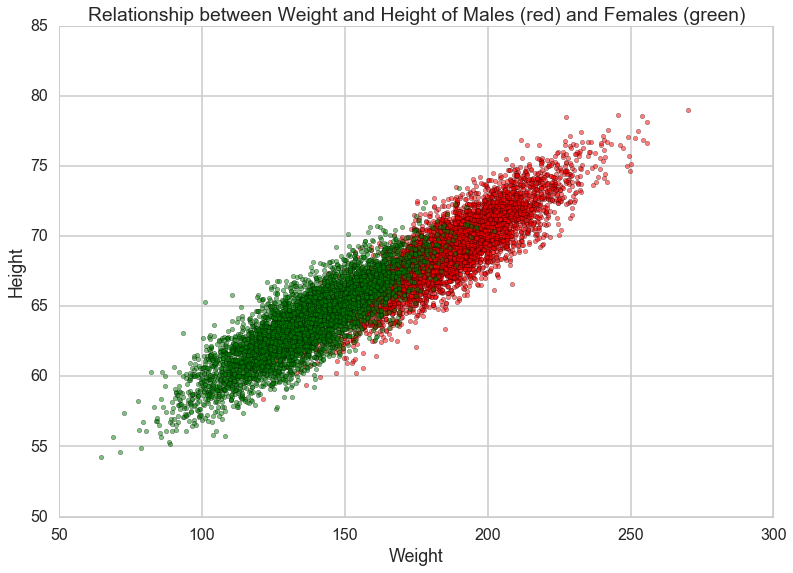

In [4]:

plt.scatter(dflog_m.Weight,dflog_m.Height, c = 'r', alpha = 0.5 )
plt.scatter(dflog_f.Weight,dflog_f.Height, c = 'g', alpha = 0.5)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Relationship between Weight and Height of Males (red) and Females (green)")

In the Linear Regression Mini Project, the last (extra credit) exercise was to write a K-Fold cross-validation. Feel free to use that code below, or just use the `cv_score` function we've provided. 

In [5]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

NameError: name 'x' is not defined

First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [8]:
from sklearn.cross_validation import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender=="Male").values,random_state=5)

2500

In [9]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(Xlr,ylr)
print (accuracy_score(clf.predict(Xtestlr),ytestlr))

0.9252


In [10]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print (score)

0.917066666667


While this looks like a pretty great model, we would like to ensure two things:

* We have found the best model (in terms of model parameters).
* The model is highly likely to generalize i.e. perform well on unseen data.

For tuning your model, you will use a mix of *cross-validation* and *grid search*. In Logistic Regression, the most important parameter to tune is the *regularization parameter* `C`. You will now implement some code to perform model tuning. 

**Your turn:** Implement the following search procedure to find a good model

* You are given a list of possible values of `C` below
* For each C:
  * Create a logistic regression model with that value of C
  * Find the average score for this model using the `cv_score` function **only on the training set** `(Xlr,ylr)`
* Pick the C with the highest average score

Your goal is to find the best model parameters based *only* on the training set, without showing the model test set at all (which is why the test set is also called a *hold-out* set).

In [17]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
score_max = 0
#your turn
for C in Cs:
    clf = LogisticRegression()
    score = cv_score(clf, Xlr, ylr)
    if score > score_max:
        score_max = score
        highest_C = C
print(score_max, highest_C)
    


0.917066666667 0.001


**Your turn:** Now you want to estimate how this model will predict on unseen data in the following way:

* Use the C you obtained from the procedure earlier and train a Logistic Regression on the training data
* Calculate the accuracy on the test data

In [19]:
#your turn
clfl=LogisticRegression(C=highest_C)
clfl.fit(Xlr, ylr)
prediction=clfl.predict(Xtestlr)
accuracy_score(prediction, ytestlr)

0.92559999999999998

**Things to think about**

You may notice that this particular value of `C` may or may not do as well as simply running the default model on a random train-test split. 

* Do you think that's a problem? 
* Why do we need to do this whole cross-validation and grid search stuff anyway?

### Use scikit-learn's GridSearchCV tool

**Your turn (extra credit):** Use scikit-learn's [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) tool to perform cross validation and grid search. 

* Instead of writing your own loops above to iterate over the model parameters, can you use GridSearchCV to find the best model over the training set? 
* Does it give you the same best value of `C`?
* How does this model you've obtained perform on the test set?

In [20]:
#your turn
from sklearn.grid_search import GridSearchCV
clfl2=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 {'C': 0.001},
 0.91720000000000002,
 [mean: 0.91533, std: 0.00321, params: {'C': 0.0001},
  mean: 0.91720, std: 0.00230, params: {'C': 0.001},
  mean: 0.91693, std: 0.00235, params: {'C': 0.1},
  mean: 0.91693, std: 0.00235, params: {'C': 1},
  mean: 0.91693, std: 0.00235, params: {'C': 10},
  mean: 0.91693, std: 0.00235, params: {'C': 100}])

In [21]:
clfl2=LogisticRegression(C=fitmodel.best_params_['C'])
clfl2.fit(Xlr, ylr)
prediction2=clfl2.predict(Xtestlr)
accuracy_score(prediction2, ytestlr)

0.92559999999999998